# **Loan Data Analysis using Lending Club Data**

In [235]:
# Imports
import os
import pandas as pd
from pandas import Series, DataFrame
import pandas_profiling

pd.set_option('display.max_rows', None,'display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import Imputer
from sklearn import metrics
from sklearn import linear_model
from sklearn import cross_validation

 
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import preprocessing


# ignore Deprecation Warning
import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning,RuntimeWarning) 
warnings.filterwarnings("ignore") 

plt.style.use('fivethirtyeight') # Good looking plots
pd.set_option('display.max_columns', None) # Display any number of columns


# Table of Contents
1. [Introduction](#intro)
2. [Import the data](#importdata)
3. [Target Variable](#targetvariable)
4. [Feature Selection](#featureselection)  
    4.1 [Drop features missing too much data](#missing_data)  
    4.2 [Remove "cheat" data](#cheat_data)  
    4.3 [Inspect the remaining features one by one (EDA)](#inspect)  
5. [Feature Engineering](#featureeng)  
    5.1 [Dummy variables](#dummies)  
    5.2 [Train/Test data split](#split)  
    5.3 [Imputing missing values](#imputing)  
    5.4 [Feature Scaling](#scaling)  
6. [Modeling](#modeling)  
    6.1 [Establish the baseline](#baseline)  
    6.2 [ML models](#models)  
7. [Hyperparameter tuning on the best model](#hyper)  
8. [Evaluate the best model on the testing set](#evaluate)  

Additionally: 
[MyGitHub](https://github.com/yanxiali)

## 1. Introduction
<a id="intro"></a>
The objective is to use the loan data to build a model that can predict the loan status (whether or not a loan will be fully paid or charged off) and interpret the results to find the factors which affect the result.  

We want to develop a model that is **accurate** and **interpretable**.

This problem is a binary classification as I have only two classes to predict.

## 2. Data
<a id="importdata"></a>

In this project, I will work with the publicly available Lending Club data on [Kaggle](https://www.kaggle.com/wordsforthewise/lending-club). The original dataset is from 2007 to 2017Q3, which is too large for my computer. Therefore I select the data only in 2017Q3 ([code]) and perform the following analysis. 

In [2]:
#df = pd.read_csv('../input/accepted_2007_to_2017Q3.csv.gz',compression='zip',low_memory=True)

In [3]:
df = pd.read_csv('../input/accepted_2017.csv.gz',compression='gzip',low_memory=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324931 entries, 0 to 324930
Columns: 150 entries, id to settlement_term
dtypes: float64(114), int64(1), object(35)
memory usage: 371.9+ MB


In [5]:
df.dtypes

id                                              int64
member_id                                     float64
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                      float64
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
desc                        

In [6]:
df.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
70211,106846278,NaN,8000.0,8000.0,8000.0,36 months,7.99,250.66,A,A5,Assembly,3 years,MORTGAGE,70000.0,Source Verified,May-2017,Current,n,NaN,debt_consolidation,Debt consolidation,972xx,OR,30.10,0.0,May-2005,715.0,719.0,0.0,29.0,NaN,16.0,0.0,24566.0,54.2,35.0,w,6590.34,6590.34,1751.07,1751.07,1409.66,341.41,0.0,0.0,0.0,Dec-2017,250.66,Jan-2018,Dec-2017,709.0,705.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,356353.0,0.0,3.0,0.0,1.0,13.0,28429.0,34.0,0.0,1.0,13259.0,47.0,45300.0,1.0,10.0,1.0,3.0,22272.0,12356.0,63.3,0.0,0.0,121.0,132.0,13.0,13.0,4.0,31.0,NaN,5.0,29.0,0.0,3.0,4.0,6.0,9.0,14.0,12.0,17.0,4.0,16.0,0.0,0.0,0.0,0.0,97.1,16.7,0.0,0.0,418768.0,52995.0,33700.0,64174.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
234187,118234399,NaN,3600.0,3600.0,3600.0,36 months,10.42,116.88,B,B3,Senior Associate,2 years,MORTGAGE,70000.0,Not Verified,Sep-2017,Current,n,NaN,credit_card,Credit card refinancing,490xx,MI,20.81,0.0,Aug-2002,660.0,664.0,0.0,26.0,NaN,25.0,0.0,12877.0,74.4,48.0,w,3340.90,3340.90,346.47,346.47,259.10,87.37,0.0,0.0,0.0,Dec-2017,116.88,Jan-2018,Dec-2017,674.0,670.0,0.0,33.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,335180.0,1.0,18.0,0.0,1.0,13.0,143845.0,131.0,2.0,4.0,5615.0,123.0,17300.0,3.0,1.0,3.0,6.0,13407.0,500.0,95.3,0.0,0.0,181.0,124.0,1.0,1.0,1.0,8.0,39.0,1.0,39.0,5.0,3.0,5.0,3.0,7.0,34.0,6.0,13.0,5.0,25.0,0.0,0.0,0.0,2.0,78.3,66.7,0.0,0.0,308679.0,156722.0,10600.0,109730.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,N

In [7]:
def missing_values_table(df):
     # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
        
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
     # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[ mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
        
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [8]:
missing_values_table(df)

Your selected dataframe has 150 columns.
There are 62 columns that have missing values.


,Missing Values,% of Total Values
member_id,324931,100.0
desc,324931,100.0
debt_settlement_flag_date,324788,100.0
settlement_percentage,324788,100.0
settlement_amount,324788,100.0
settlement_date,324788,100.0
settlement_status,324788,100.0
settlement_term,324788,100.0
orig_projected_additional_accrued_interest,324251,99.8
deferral_term,324180,99.8


There are a few columns missing a significant amount of values (>48.6%). These features will be dropped. Because there are many features (150+), i will drop unnecessary ones first and then deal with the remaining features more in detail. 

## 3. Target Variable
<a id="targetvariable"></a>

We are trying to predict the loan_status column. Let's check the value distributions in this column first

In [9]:
df['loan_status'].value_counts()

Current               285047
Fully Paid             27576
Late (31-120 days)      5044
Charged Off             3036
In Grace Period         2661
Late (16-30 days)       1564
Default                    3
Name: loan_status, dtype: int64

We will try to distinguish 2 cases: loans being fully paid or charged off, assuming that they both meet the credit policy. 
We will only keep the rows with loan_status being "fully paid" or "charged off". 

In [10]:
df = df.loc[df['loan_status'].isin(['Fully Paid','Charged Off'])]

In [11]:
df['loan_status'].value_counts(normalize=False, dropna=False)

Fully Paid     27576
Charged Off     3036
Name: loan_status, dtype: int64

In [12]:
df['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.900823
Charged Off    0.099177
Name: loan_status, dtype: float64

About 90% (~27k) of the loans have been fully paid, and 10% (3k) have been charged off. Kind of unbalanced data. I will try to handle this unbalance in the cross validation.

Our target variable is ready now. We have two classes to try to predict.

## 4. Feature Selection
<a id="featureselection"></a>

The raw data has 150 features, but not all of them are useful. 
Definitions of the columns are given in the Lending Club "Data Dictionary" [available here](https://www.lendingclub.com/info/download-data.action).

We will drop the features with the following criteria:
- More than 50% of the data is missing
- The feature would not have been available at the time of the loan application ("issue_d")

### 4.1 Drop features missing too much data
<a id="missing_data"></a>

In [13]:
missing_values_table(df)

Your selected dataframe has 150 columns.
There are 59 columns that have missing values.


,Missing Values,% of Total Values
member_id,30612,100.0
desc,30612,100.0
next_pymnt_d,30612,100.0
orig_projected_additional_accrued_interest,30601,100.0
hardship_dpd,30591,99.9
hardship_length,30591,99.9
hardship_status,30591,99.9
deferral_term,30591,99.9
hardship_amount,30591,99.9
hardship_start_date,30591,99.9


From this table, we can see that there is a huge gap between features missing some data and those missing lots of data. 
I chose 49% as the cutoff.

In [14]:
missing_frac = df.isnull().mean()
drop_list = sorted(missing_frac[missing_frac > 0.48].index)

In [15]:
print(drop_list)

['annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts', 'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util', 'settlement_amount', 'settlement_date', 'settlement_percentage', 'settlem

In [16]:
len(drop_list)

44

In [17]:
def drop_cols(cols):
    df.drop(labels=cols, axis=1, inplace=True)

In [18]:
drop_cols(drop_list)

In [19]:
df.shape

(30612, 106)

### 4.2 Remove "cheat" data
<a id="cheat_data"></a>

The goal of this project is to predict whether a loan will be paid off BEFORE making the decision to lend the loan. Therefore, we would like to remove the features that were unavailable before lending a loan.  

In [20]:
print(sorted(df.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'il_util', 'initial_list_status', 'inq_fi', 'inq_last_12m', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_

We check the definition of these features and drop the ones that would have not been availalbe before a load was lended. 

In [21]:
#drop_list = ['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'funded_amnt', 'funded_amnt_inv', 'inq_last_6mths', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'recoveries', 'revol_bal', 'revol_util', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim']

In [22]:
drop_list = ['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'inq_last_6mths', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pymnt_plan', 'recoveries', 'revol_bal', 'revol_util', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_acc', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']

In [23]:
len(drop_list)

76

In [24]:
df.drop(labels=drop_list, axis=1, inplace=True)

In [25]:
df.shape

(30612, 30)

### 4.3 Inspect the remaining features one by one
<a id="inspect"></a>

Now we are left with reasonable number of features (30), and we will further check these and perform EDA analysis if necessary, including:

- Missing data and outliers
- Cleaning & Formatting: 
    - Histogram of the to-be-checked feature & its relation to the target variable.  
- Transformation of features
- choose the most relevant features in the data

I will start with defining some useful plotting functions, including:
1. single value plots + relationships with the loan_status
2. relationships between variables: Pearson correlation coefficient. 
3. pairs plot

In [26]:
def plot_var(col_name, full_name, continuous):
    """ 
    Visualize a variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True for continuous variables
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(10,4))
    # plot without loan status
    if continuous:
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)
    # plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        fully_paid_rates = df.groupby(col_name)['loan_status'].value_counts(normalize=True)[:,'Fully Paid']
        sns.barplot(x=fully_paid_rates.index, y=fully_paid_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Fully Paid')
        ax2.set_title('Fully Paid Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

In [27]:
#def plot_coeff

In [28]:
#def plot_pairs

What are the remaining features?

In [29]:
print(list(df.columns))

['id', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'pub_rec', 'initial_list_status', 'policy_code', 'application_type', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc', 'pub_rec_bankruptcies']


In [30]:
df.dtypes

id                        int64
loan_amnt               float64
term                     object
int_rate                float64
installment             float64
grade                    object
sub_grade                object
emp_title                object
emp_length               object
home_ownership           object
annual_inc              float64
verification_status      object
issue_d                  object
loan_status              object
purpose                  object
title                    object
zip_code                 object
addr_state               object
dti                     float64
earliest_cr_line         object
fico_range_low          float64
fico_range_high         float64
pub_rec                 float64
initial_list_status      object
policy_code             float64
application_type         object
mo_sin_old_il_acct      float64
mo_sin_old_rev_tl_op    float64
mort_acc                float64
pub_rec_bankruptcies    float64
dtype: object

### Features one-by-one
I will screen each feature and decide if a feature should be dropped. I will do an EDA analysis for each feature. 

### id
Data Dictionary: "A unique assigned ID for the loan listing."

In [31]:
df['id'].sample(5)

185285     95815272
170070     97433980
57503     103238825
131688    100457891
58875     107471872
Name: id, dtype: int64

In [32]:
len(df['id'])

30612

In [33]:
len(df['id'].unique())

30612

"id" is a unique index. It's not useful as a categorical variable (so many unique values), nor as a numerical variable (a wild range of its values). Therefore I will drop this feature. 

In [34]:
df.drop(labels='id', axis=1, inplace=True)

### loan_amnt
Data Dictionary: "The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."

In [35]:
df['loan_amnt'].describe()

count    30612.000000
mean     14061.154939
std       9529.745282
min       1000.000000
25%       6400.000000
50%      12000.000000
75%      20000.000000
max      40000.000000
Name: loan_amnt, dtype: float64

"loan_amnt" range from \$1k to \$40 k, with a median of 12k. 

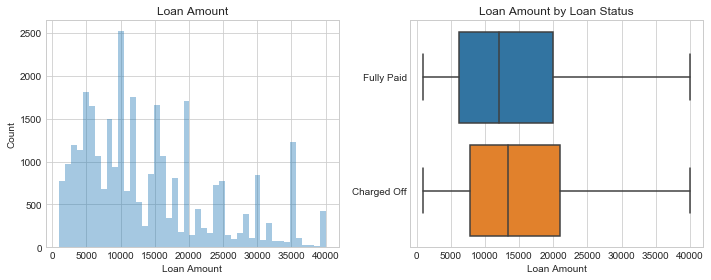

In [36]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

"Charged off" loans have higher loan amount. 

### term
Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60."

In [37]:
df['term'].sample(5)

16937      36 months
287791     36 months
159652     36 months
161712     60 months
240707     36 months
Name: term, dtype: object

In [38]:
df['term'].value_counts(dropna=False)

 36 months    23414
 60 months     7198
Name: term, dtype: int64

We convert "term" to integers

In [39]:
df['term'] = df['term'].apply(lambda s: np.int8(s.split()[0]))

In [40]:
df['term'].value_counts(normalize=True)

36    0.764863
60    0.235137
Name: term, dtype: float64

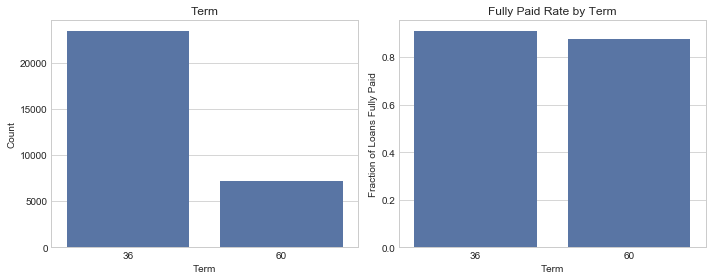

In [41]:
plot_var('term', 'Term', continuous=False)

About 76% of the loans are 36 months and the rest are 60 months. The latter tends to have lower fraction of being fully paid.

### int_rate
Data Dictionary: "Interest Rate on the loan."

In [42]:
df['int_rate'].describe()

count    30612.000000
mean        14.536800
std          5.903335
min          5.320000
25%         10.910000
50%         13.490000
75%         16.990000
max         30.990000
Name: int_rate, dtype: float64

The interest rage ranges from 5% to 31%, with a median at 13%. 

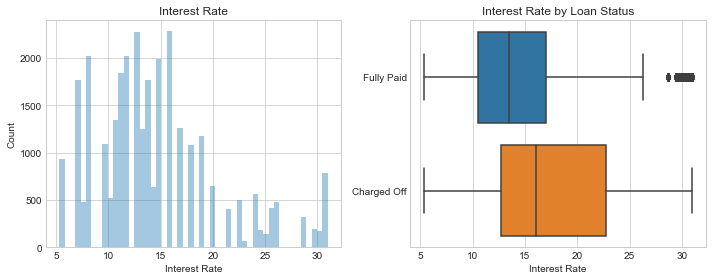

In [43]:
plot_var('int_rate', 'Interest Rate', continuous=True)

The higher the interest rate is, the more likely for being charged off. 
There are some outliers in the Fully Paid dataset. Let's take a look at them, as outliers may distort ML analysis. 

In [44]:
df.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,3036.0,17.651439,6.234868,5.32,12.74,16.02,22.74,30.99
Fully Paid,27576.0,14.193891,5.763857,5.32,10.49,13.49,16.99,30.99


Any values > 75% percentile (22.74) are defined as outliers. 

In [45]:
df.groupby('loan_status')['int_rate'].value_counts()['Fully Paid'].sort_index()

int_rate
5.32      911
6.00        3
6.99      427
7.07      320
7.21      275
7.24      437
7.35      263
7.49      469
7.97      402
7.99      609
8.24      919
9.44      540
9.93      524
10.42     504
10.49     762
10.91     521
11.39     818
11.44     867
11.49    1291
11.99     590
12.62     615
12.74    1443
13.49    1112
13.59     608
13.99     968
14.08     612
14.99    1100
15.05     700
15.99    1153
16.02     882
16.99     834
17.09     209
17.99     605
18.06     322
18.99     629
19.03     372
19.99     336
20.00     199
21.45     272
21.49      91
22.74     391
22.91      62
23.88     150
23.99     296
24.74     144
24.85     124
25.49     231
25.82     111
26.24     179
26.30     230
28.69     211
28.72      29
29.49      91
29.69      59
29.99      84
30.17      54
30.49      67
30.65      55
30.74      46
30.75      43
30.79     109
30.84      73
30.89      64
30.94      83
30.99      76
Name: int_rate, dtype: int64

In [46]:
#? how to get the total number of int_rates> 22.74?

### installment
Data Dictionary: "The monthly payment owed by the borrower if the loan originates."

In [47]:
df['installment'].describe()

count    30612.000000
mean       438.463252
std        297.664796
min         30.120000
25%        216.020000
50%        356.780000
75%        594.620000
max       1714.540000
Name: installment, dtype: float64

Installments range from \$30 to $1715, with a median at \$357. 

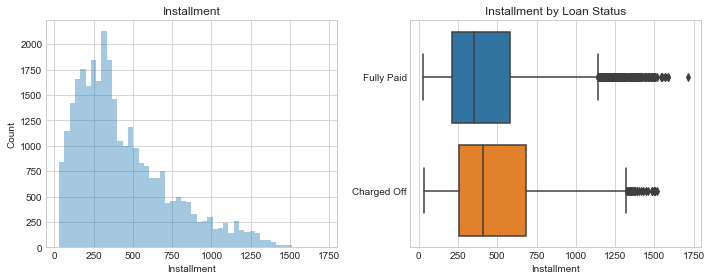

In [48]:
plot_var('installment', 'Installment', continuous=True)

Charged-off loans tend to have higher installments

### grade, sub_grade
Data Dictionary for grade: "assigned loan grade."
Data Dictionary for sub_grade: "LC assigned loan subgrade."

What are the possible values of grade and sub_grade?

In [49]:
sorted(df['grade'].unique())

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [50]:
print(sorted(df['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The "grade" is included in the "sub_grade" column, so it could be dropped.

In [51]:
df.drop(labels='grade',axis=1,inplace=True)

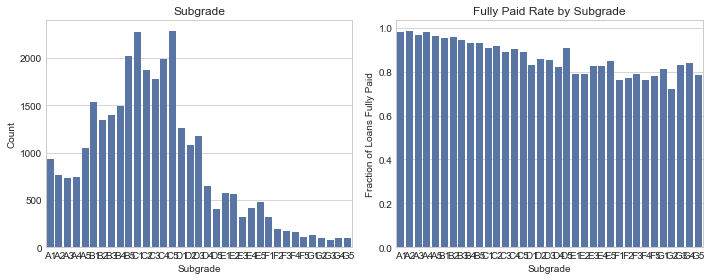

In [52]:
plot_var('sub_grade','Subgrade',continuous=False)

There is a trend of lower fraction of loans fully paid as the subgrade going from A to G.

### emp_title
Data Dictionary: "The job title supplied by the Borrower when applying for the loan."

In [53]:
df['emp_title'].describe()

count       28553
unique      13990
top       Manager
freq          596
Name: emp_title, dtype: object

In [54]:
df['emp_title'].sample(5)

186718          Small Business Banker
110956                Sales Associate
4860      SC SR LEAD DELIVERY MANAGER
68232                    cnc operator
156832            Project Coordinator
Name: emp_title, dtype: object

There are too many unique titles for this feature to be useful, so we drop this feature. 

In [55]:
drop_cols('emp_title')

### emp_length
Data Dictionary: "Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years." The actual data does not match this description:

In [56]:
df['emp_length'].value_counts(dropna=False).sort_index()

1 year        1909
10+ years    10904
2 years       2742
3 years       2430
4 years       1826
5 years       1915
6 years       1387
7 years       1079
8 years        935
9 years       1158
< 1 year      2297
NaN           2030
Name: emp_length, dtype: int64

There are 2030 loans without the information on emp_length. Convert this feature to integers. 

In [57]:
df['emp_length'].replace('10+ years', '10 years', inplace=True)

In [58]:
df['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [59]:
df['emp_length'].value_counts(dropna=False).sort_index()

0 years      2297
1 year       1909
10 years    10904
2 years      2742
3 years      2430
4 years      1826
5 years      1915
6 years      1387
7 years      1079
8 years       935
9 years      1158
NaN          2030
Name: emp_length, dtype: int64

In [60]:
df.emp_length.map( lambda x: str(x).split()[0]).value_counts().sort_index()

0       2297
1       1909
10     10904
2       2742
3       2430
4       1826
5       1915
6       1387
7       1079
8        935
9       1158
nan     2030
Name: emp_length, dtype: int64

In [61]:
df['emp_length'] = df.emp_length.map( lambda x: str(x).split()[0])

In [62]:
df['emp_length'].sample(5)

169329     0
114889     6
180554     5
86041     10
317661     1
Name: emp_length, dtype: object

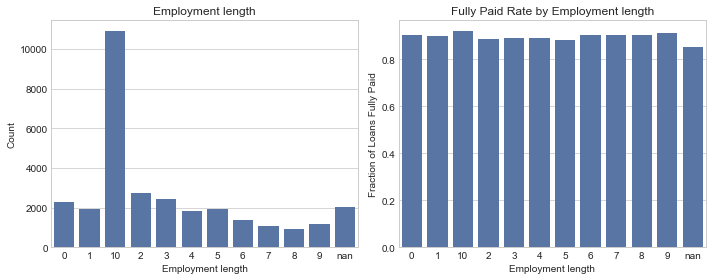

In [63]:
plot_var('emp_length', 'Employment length', continuous=False)

One third of the loans go to the people with longer than 10 years of employments. However, the fully paid rate seems not quite related to this feature. 

### home_ownership
Data Dictionary: "The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER."

In [64]:
df['home_ownership'].value_counts()

MORTGAGE    16216
RENT        10442
OWN          3879
ANY            74
NONE            1
Name: home_ownership, dtype: int64

Replace "ANY" & "None" with "OTHERS". 

In [65]:
df['home_ownership'].replace(['NONE','ANY'],'OTHERS', inplace=True)

In [66]:
df['home_ownership'].value_counts()

MORTGAGE    16216
RENT        10442
OWN          3879
OTHERS         75
Name: home_ownership, dtype: int64

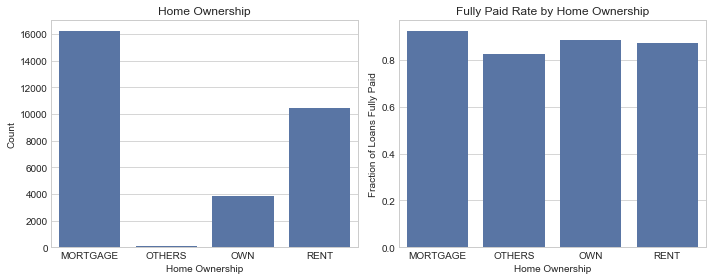

In [67]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

There appear to be small differences in charge-off rates by home ownership status. Renters have slightly less probability of fully paying off the loan. Because of the large numbers of observations in each category, these differences are statistically significant.

### annual_inc
Data Dictionary: "The self-reported annual income provided by the borrower during registration."

In [68]:
df['annual_inc'].describe()

count    3.061200e+04
mean     8.219195e+04
std      8.182641e+04
min      0.000000e+00
25%      5.000000e+04
50%      7.000000e+04
75%      1.000000e+05
max      8.300000e+06
Name: annual_inc, dtype: float64

Annual income ranges from \$0 to \$8M, with a median at \$70k, which doubles the national median individual income in the US.
Due to the large range of variation, we log-transform the values.

In [69]:
df['annual_inc'] = df['annual_inc'].apply(lambda x:np.log10(x+1))

In [70]:
df['annual_inc'].describe()

count    30612.000000
mean         4.842359
std          0.266596
min          0.000000
25%          4.698979
50%          4.845104
75%          5.000004
max          6.919078
Name: annual_inc, dtype: float64

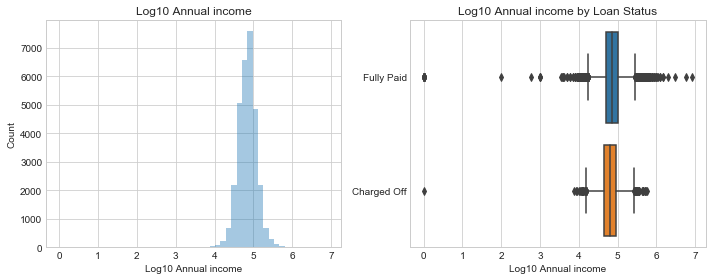

In [71]:
plot_var('annual_inc', 'Log10 Annual income', continuous=True)

Let's look closer of the difference here

In [72]:
df.groupby('loan_status')['annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,3036.0,4.808561,0.262072,0.0,4.653222,4.812920,4.962438,5.767898
Fully Paid,27576.0,4.846080,0.266832,0.0,4.698979,4.845104,5.000004,6.919078


The difference in the median is ~\$5000, which is significant. For both cases, there are quite a few outliers. 

### verication_status
Data Dictionary: "Indicates if income was verified by [Lending Club], not verified, or if the income source was verified."

In [73]:
df['verification_status'].value_counts()

Source Verified    12048
Not Verified       10032
Verified            8532
Name: verification_status, dtype: int64

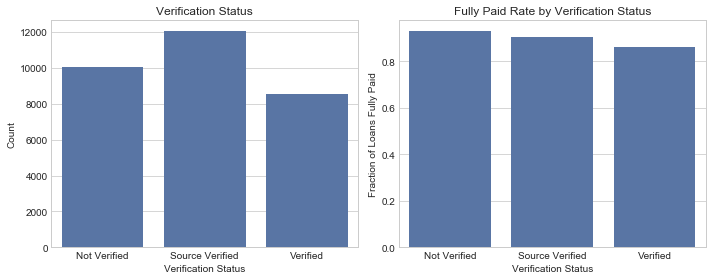

In [74]:
plot_var('verification_status', 'Verification Status', continuous=False)

### issue_d
Data Dictionary: "The month which the loan was funded.

Because we are only using the variables that are available before the loan was funded to make predictions, issue_d will not be included in modeling. This feature is kept here for train/test sample split, after which this feature will be dropped. 

### purpose
Data Dictionary: "A category provided by the borrower for the loan request."

In [75]:
df['purpose'].value_counts()

debt_consolidation    16577
credit_card            5629
home_improvement       2800
other                  2425
major_purchase          882
medical                 539
car                     462
vacation                365
moving                  328
small_business          311
house                   272
renewable_energy         22
Name: purpose, dtype: int64

Now let's check the fully paid rates of purposes.

In [76]:
df.groupby('purpose')['loan_status'].value_counts(normalize=True)[:,'Fully Paid'].sort_values(ascending=False)

purpose
house                 0.948529
car                   0.924242
credit_card           0.912773
home_improvement      0.908571
major_purchase        0.903628
vacation              0.901370
debt_consolidation    0.899620
other                 0.887010
moving                0.868902
renewable_energy      0.863636
medical               0.851577
small_business        0.823151
Name: loan_status, dtype: float64

We see that, 94% of the loans for house are fully paid, but only 82% of small business are fully paid.

### title
Data Dictionary: "The loan title provided by the borrower."

In [77]:
df['title'].value_counts()

Debt consolidation         16576
Credit card refinancing     5630
Home improvement            2800
Other                       2425
Major purchase               881
Medical expenses             539
Car financing                462
Vacation                     365
Moving and relocation        328
Business                     312
Home buying                  272
Green loan                    22
Name: title, dtype: int64

In [78]:
df['title'].describe()

count                  30612
unique                    12
top       Debt consolidation
freq                   16576
Name: title, dtype: object

In [79]:
df['title'].value_counts().head(10)

Debt consolidation         16576
Credit card refinancing     5630
Home improvement            2800
Other                       2425
Major purchase               881
Medical expenses             539
Car financing                462
Vacation                     365
Moving and relocation        328
Business                     312
Name: title, dtype: int64

There are 12 unique purposes in the dataset, and from the top 10 titles, it seems that this information is covered in the "purpose". So we drop this column. 

In [80]:
drop_cols('title')

### zip_code, addr_stat
Data Dictionary for zip_code: "The first 3 numbers of the zip code provided by the borrower in the loan application."  
Data Dictionary for addr_state: "The state provided by the borrower in the loan application."  

In [81]:
df['zip_code'].describe()

count     30612
unique      828
top       945xx
freq        372
Name: zip_code, dtype: object

In [82]:
df['addr_state'].describe()

count     30612
unique       49
top          CA
freq       4567
Name: addr_state, dtype: object

There are many unique "zip_code" values, and the zip_code info should be equivalent to "addr_stat". Therefore we drop the "zip_code". 

In [83]:
drop_cols('zip_code')

In [84]:
df.groupby('addr_state')['loan_status'].value_counts(normalize=True)[:,'Fully Paid'].sort_values(ascending=False)

addr_state
ME    0.958333
HI    0.950549
ID    0.945652
DC    0.940299
DE    0.930233
CO    0.926239
UT    0.924658
AZ    0.924528
SC    0.924433
SD    0.921569
OR    0.920918
WI    0.920635
RI    0.920290
NH    0.917722
WA    0.916780
KS    0.914141
GA    0.910560
NC    0.910543
VT    0.909091
VA    0.908033
IL    0.906500
CT    0.906250
NE    0.906040
AR    0.904545
IN    0.903409
MI    0.903226
OH    0.902985
AL    0.901685
LA    0.900000
WY    0.900000
AK    0.900000
ND    0.900000
MN    0.898955
CA    0.897526
KY    0.896552
FL    0.896504
TN    0.896414
NY    0.894407
MS    0.894366
NV    0.892989
PA    0.892000
MD    0.889510
TX    0.888757
MA    0.888563
NJ    0.885687
NM    0.878205
MO    0.876623
MT    0.847222
OK    0.828571
Name: loan_status, dtype: float64

ME has the highest fraction of fully paid (0.96), whereas OK has the lowest fraction at 0.83. 

### dti
Data Dictionary: "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."

In [85]:
df['dti'].describe()

count    30593.000000
mean        17.943821
std         14.094662
min          0.000000
25%         11.440000
50%         17.170000
75%         23.640000
max        999.000000
Name: dti, dtype: float64

The values of 0 or 999 are probably outliers. Let's look at its histogram .

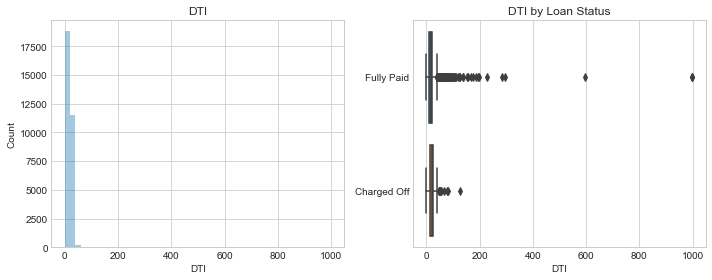

In [86]:
plot_var('dti', 'DTI', continuous=True)

Text(0.5,1,'DTI by loan status')

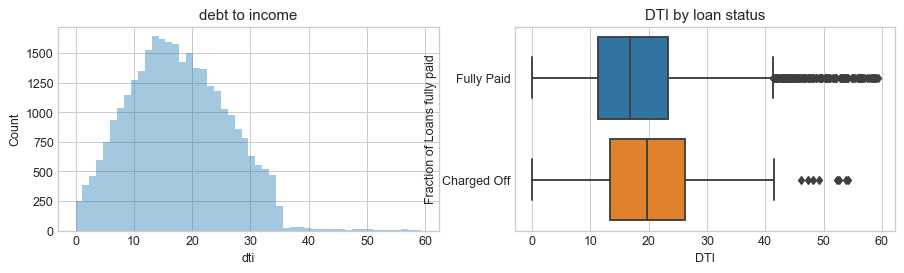

In [87]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.distplot(df.loc[df['dti'].notnull() & (df['dti'] < 60), 'dti'], kde=False, ax=ax1)
ax1.set_xlabel('dti')
ax1.set_ylabel('Count')
ax1.set_title('debt to income')
sns.boxplot(x=df.loc[df['dti'].notnull() & (df['dti'] < 60), 'dti'], y='loan_status', data=df, ax=ax2)
ax2.set_xlabel('DTI')
ax2.set_ylabel('Fraction of Loans fully paid')
ax2.set_title('Fully paid rate by debt to income')
ax2.set_title('DTI by loan status')

In [88]:
(df['dti'] > 60).sum() / (df['dti']).sum()

0.00015301791774237656

Very few outliers with dti > 60. 

From the figure it seems that the Fully paid loans have smaller DTI. Let's check. 

In [89]:
df.groupby('loan_status')['dti'].median()

loan_status
Charged Off    19.78
Fully Paid     16.89
Name: dti, dtype: float64

It's clear that borrowers who have lower DTI are more likely to fully pay the loans. 

### earliest_cr_line
Data Dictionary: "The month the borrower's earliest reported credit line was opened."

In [90]:
df['earliest_cr_line'].sample(5)

139504    Aug-2006
172972    Nov-2003
103645    Nov-2003
158590    Mar-2003
125496    Mar-2003
Name: earliest_cr_line, dtype: object

In [91]:
df['earliest_cr_line'].describe()

count        30612
unique         573
top       Sep-2004
freq           279
Name: earliest_cr_line, dtype: object

In [92]:
df['earliest_cr_line'].isnull().any()

False

There are no null inputs in this column. Let's extract the year and month . To maximum the time information, we translate month into year, e.g., Jan: 1/12 year, Feb: 2/12 year, etc.

In [93]:
df['earliest_cr_line_Year'] = df['earliest_cr_line'].apply(lambda s: np.int(s.split('-')[1]))

In [94]:
df['earliest_cr_line_Year'].value_counts()

2004    2351
2005    2348
2003    2233
2006    2110
2002    1972
2001    1773
2000    1579
1999    1453
2007    1451
1998    1149
1997    1114
1996     978
1995     902
2008     810
1994     782
1993     662
2009     623
2011     590
2010     567
2012     516
1992     471
1991     448
1990     447
2013     433
1989     398
1988     370
1987     360
1986     256
1985     221
1984     193
1983     172
1982     137
1981      92
1979      79
1978      72
2014      69
1977      67
1980      60
1976      57
1975      40
1974      37
1972      35
1973      34
1970      19
1971      17
1968      16
1969      13
1964       8
1967       8
1965       6
1966       5
1962       4
1961       3
1958       1
1960       1
Name: earliest_cr_line_Year, dtype: int64

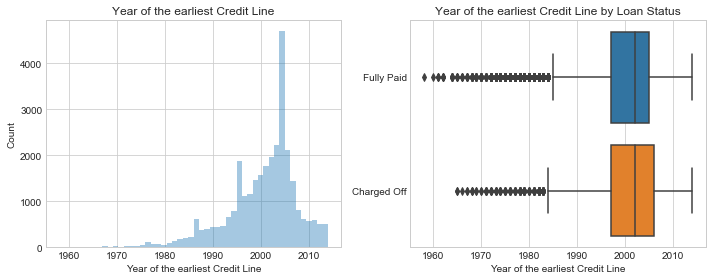

In [95]:
plot_var('earliest_cr_line_Year', 'Year of the earliest Credit Line', continuous=True)

Borrowers who charged off have opened their first credit line more recently, althought their median are almost the same.

In [96]:
df.groupby('loan_status')['earliest_cr_line_Year'].mean()
#df.groupby('earliest_cr_line_Year')['loan_status'].median()

loan_status
Charged Off    2000.520422
Fully Paid     2000.348999
Name: earliest_cr_line_Year, dtype: float64

In [97]:
#df.groupby('earliest_cr_line_Year')['loan_status'].value_counts(normalize=True)[:,'Fully Paid'].sort_index()

In [98]:
drop_cols('earliest_cr_line')

### fico_range_low, fico_range_high
Data Dictionary for fico_range_low: "The lower boundary range the borrower’s FICO at loan origination belongs to."  
Data Dictionary for fico_range_high: "The upper boundary range the borrower’s FICO at loan origination belongs to."

In [99]:
df[['fico_range_low','fico_range_high']].describe()

,fico_range_low,fico_range_high
count,30612.000000,30612.000000
mean,699.767085,703.767411
std,34.727898,34.729269
min,660.000000,664.000000
25%,675.000000,679.000000
50%,690.000000,694.000000
75%,715.000000,719.000000
max,845.000000,850.000000


Check the correlation between the two:

In [100]:
df[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


These two are highly correlated, therefore we only need to keep one. 

In [101]:
drop_cols('fico_range_low')

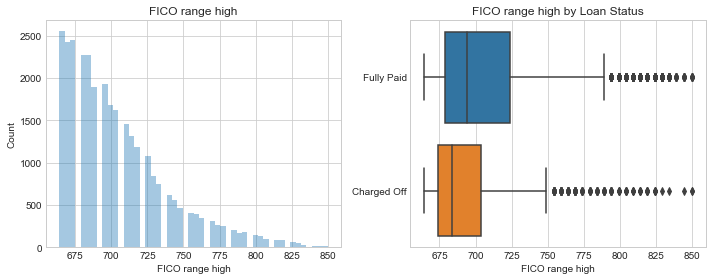

In [102]:
plot_var('fico_range_high', 'FICO range high', continuous=True)

There is noticeable difference in FICO scores between fully paid and charged-off loans.

### pub_rec
Data Dictionary: "Number of derogatory public records."

In [103]:
df['pub_rec'].value_counts().sort_values(ascending=False)

0.0     24268
1.0      5333
2.0       680
3.0       201
4.0        68
5.0        23
6.0        18
7.0         9
9.0         4
8.0         3
11.0        2
12.0        1
10.0        1
28.0        1
Name: pub_rec, dtype: int64

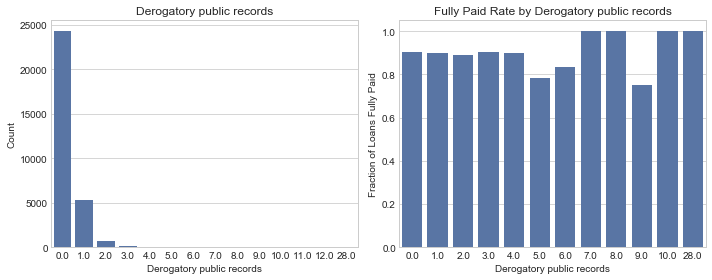

In [104]:
plot_var('pub_rec','Derogatory public records', continuous=False)

In [105]:
df.groupby('loan_status')['pub_rec'].mean()

loan_status
Charged Off    0.282938
Fully Paid     0.258449
Name: pub_rec, dtype: float64

The fully paid loans are borrowed by people with lower pub_rec values.

### initial_list_status
Data Dictionary: "The initial listing status of the loan. Possible values are – W, F."

In [106]:
df['initial_list_status'].value_counts()

w    21356
f     9256
Name: initial_list_status, dtype: int64

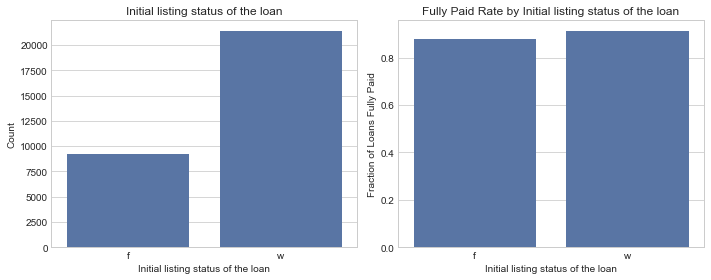

In [107]:
plot_var('initial_list_status','Initial listing status of the loan', continuous=False)

### policy_code
Data Dictionary: "publicly available policy_code=1; new products not publicly available policy_code=2"

In [108]:
df['policy_code'].value_counts()

1.0    30612
Name: policy_code, dtype: int64

All values are the same; drop this feature. 

In [109]:
drop_cols('policy_code')

### application_type
Data Dictionary: "Indicates whether the loan is an individual application or a joint application with two co-borrowers."

In [110]:
df['application_type'].value_counts()

Individual    29298
Joint App      1314
Name: application_type, dtype: int64

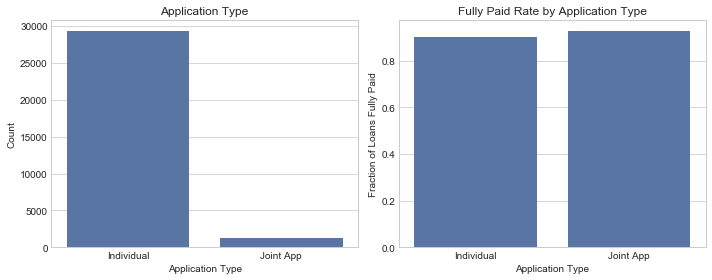

In [111]:
plot_var('application_type', 'Application Type', continuous=False)

### mo_sin_old_il_acct
Data Dictionary: "Months since oldest bank installment account opened."

In [112]:
df['mo_sin_old_il_acct'].describe()

count    29925.000000
mean       125.464662
std         52.295064
min          1.000000
25%         98.000000
50%        130.000000
75%        153.000000
max        665.000000
Name: mo_sin_old_il_acct, dtype: float64

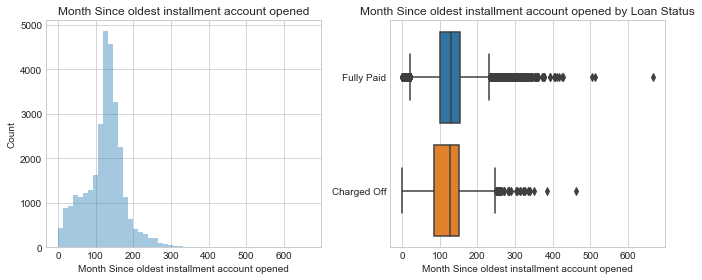

In [113]:
plot_var('mo_sin_old_il_acct', 'Month Since oldest installment account opened', continuous=True)

### mo_sin_old_rev_tl_op
Data Dictionary: "Months since oldest revolving account opened."

In [114]:
df['mo_sin_old_rev_tl_op'].describe()

count    30612.000000
mean       180.387266
std         94.921845
min          8.000000
25%        119.000000
50%        163.000000
75%        229.000000
max        677.000000
Name: mo_sin_old_rev_tl_op, dtype: float64

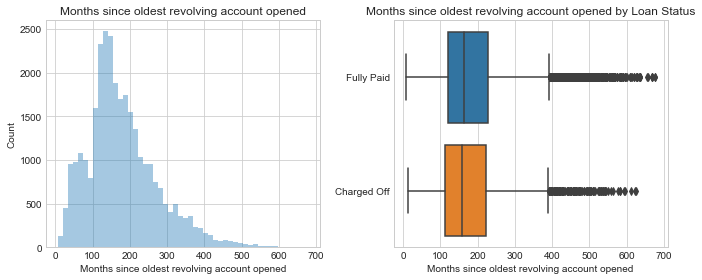

In [115]:
plot_var('mo_sin_old_rev_tl_op', 'Months since oldest revolving account opened', continuous=True)

### mort_acc
Data Dictionary: "Number of mortgage accounts."

In [116]:
df['mort_acc'].describe()

count    30612.000000
mean         1.682249
std          1.891889
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         18.000000
Name: mort_acc, dtype: float64

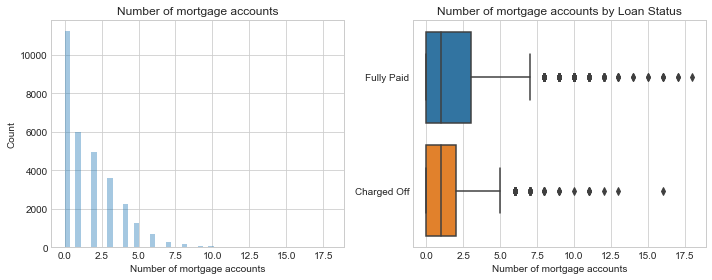

In [117]:
plot_var('mort_acc', 'Number of mortgage accounts', continuous=True)

In [118]:
df.groupby('loan_status')['mort_acc'].mean()

loan_status
Charged Off    1.282279
Fully Paid     1.726284
Name: mort_acc, dtype: float64

### pub_rec_bankruptcies
Data Dictionary: "Number of public record bankruptcies."

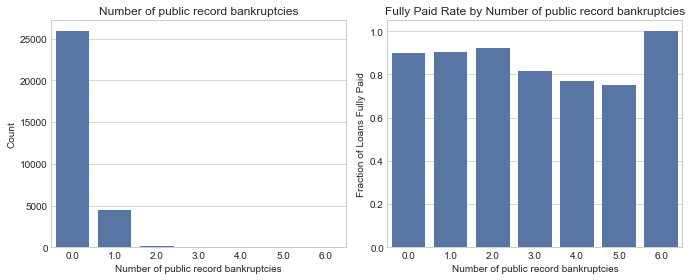

In [119]:
plot_var('pub_rec_bankruptcies', 'Number of public record bankruptcies', continuous=False)

Now we have inspected each feature and dropped some useless ones. Let's further check the remaining ones. 

In [120]:
df.shape

(30612, 23)

There are only 23 features left.

### Missing values 

In [121]:
missing_values_table(df)

Your selected dataframe has 23 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
mo_sin_old_il_acct,687,2.2
dti,19,0.1


There are 2 features with relatively small percentage of missing values.

### Outliers
- outliers can be exactly what we want to learn about, e.g., anomaly detection. 
- In this project, however, outliers may distort the picture of the data in both statistical analysis and visualization. 
- Below, I use the modified Z-score method and the IQR method. Note that the variable must be continuous, not categorical, for any of these functions to make sense.

In [122]:
drop_list = df.select_dtypes(exclude=['object']).columns

In [123]:
def outliers_modified_z_score(dataframe, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices corresponding to the observations containing more than n outliers according to the modified z-score Method
    """
    threshold = 3.5
    outlier_indices = []
    for col in features:
        median_y = np.median(dataframe[col])
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in dataframe[col]])
        modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in dataframe[col]]
        outlier_list_col = dataframe[np.abs(modified_z_scores) > threshold].index
       # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers

In [124]:
Outliers_to_drop_z_score = outliers_modified_z_score(df,2,['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti',
       'fico_range_high', 'pub_rec', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mort_acc', 'pub_rec_bankruptcies',
       'earliest_cr_line_Year'])


In [125]:
df[['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti',
       'fico_range_high', 'pub_rec', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mort_acc', 'pub_rec_bankruptcies',
       'earliest_cr_line_Year']].loc[Outliers_to_drop_z_score] # Show the outliers rows


,loan_amnt,term,int_rate,installment,annual_inc,dti,fico_range_high,pub_rec,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mort_acc,pub_rec_bankruptcies,earliest_cr_line_Year
42,10000.0,60,16.02,243.29,4.715836,10.11,694.0,2.0,130.0,54.0,0.0,2.0,2006
1044,16800.0,60,11.99,373.63,4.612794,26.38,699.0,1.0,178.0,267.0,0.0,1.0,1995
1118,17500.0,60,14.08,407.93,5.000004,13.27,709.0,1.0,149.0,130.0,0.0,1.0,2005
1202,25000.0,60,26.30,752.96,4.929424,27.38,694.0,0.0,146.0,591.0,3.0,0.0,1968
1231,24000.0,60,15.05,571.59,5.255275,11.91,679.0,1.0,135.0,308.0,0.0,1.0,1991
1557,25200.0,60,12.62,568.49,5.243041,21.00,714.0,3.0,121.0,74.0,0.0,1.0,2007
1567,18000.0,60,16.02,437.92,4.740371,35.87,699.0,1.0,136.0,162.0,0.0,1.0,2003
1982,20000.0,60,13.59,461.13,4.929424,17.75,719.0,1.0,192.0,122.0,1.0,1.0,2001
2056,28000.0,60,25.82,835.36,4.778158,14.68,684.0,1.0,124.0,211.0,3.0,1.0,1999
2779,25000.0,60,15.05,595.41,4.929424,21.81,684.0,1.0,130.0,157.0,0.0,1.0,2004


In [126]:
def outliers_iqr(dataframe, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    for col in features:
        # 1st quartile (25%) & # 3rd quartile (75%)
        quartile_1, quartile_3 = np.percentile(dataframe[col], [25,75])
        #quartile_3 = np.percentile(dataframe[col], 75)
      
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        # Determine a list of indices of outliers for feature col
        outlier_list_col = dataframe[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)].index
       # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers

In [127]:
Outliers_to_drop_iqr = outliers_iqr(df,2, ['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti',
       'fico_range_high', 'pub_rec', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mort_acc', 'pub_rec_bankruptcies',
       'earliest_cr_line_Year'])


In [128]:
df[['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti',
       'fico_range_high', 'pub_rec', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mort_acc', 'pub_rec_bankruptcies',
       'earliest_cr_line_Year']].loc[Outliers_to_drop_iqr] # Show the outliers rows


,loan_amnt,term,int_rate,installment,annual_inc,dti,fico_range_high,pub_rec,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mort_acc,pub_rec_bankruptcies,earliest_cr_line_Year
42,10000.0,60,16.02,243.29,4.715836,10.11,694.0,2.0,130.0,54.0,0.0,2.0,2006
549,40000.0,60,9.93,848.51,5.505151,16.05,714.0,0.0,137.0,243.0,10.0,0.0,1997
1044,16800.0,60,11.99,373.63,4.612794,26.38,699.0,1.0,178.0,267.0,0.0,1.0,1995
1118,17500.0,60,14.08,407.93,5.000004,13.27,709.0,1.0,149.0,130.0,0.0,1.0,2005
1202,25000.0,60,26.30,752.96,4.929424,27.38,694.0,0.0,146.0,591.0,3.0,0.0,1968
1231,24000.0,60,15.05,571.59,5.255275,11.91,679.0,1.0,135.0,308.0,0.0,1.0,1991
1557,25200.0,60,12.62,568.49,5.243041,21.00,714.0,3.0,121.0,74.0,0.0,1.0,2007
1567,18000.0,60,16.02,437.92,4.740371,35.87,699.0,1.0,136.0,162.0,0.0,1.0,2003
1982,20000.0,60,13.59,461.13,4.929424,17.75,719.0,1.0,192.0,122.0,1.0,1.0,2001
2056,28000.0,60,25.82,835.36,4.778158,14.68,684.0,1.0,124.0,211.0,3.0,1.0,1999


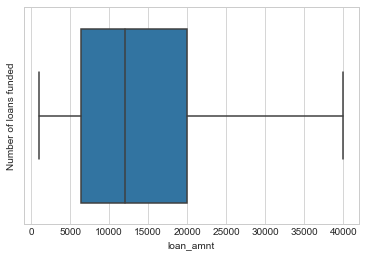

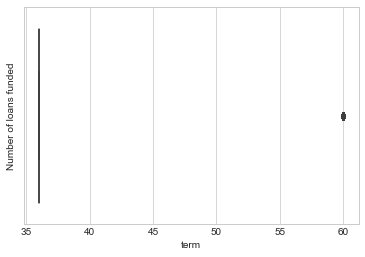

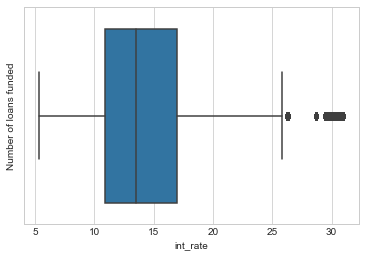

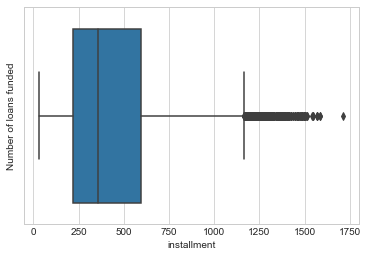

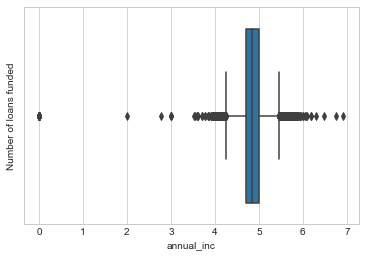

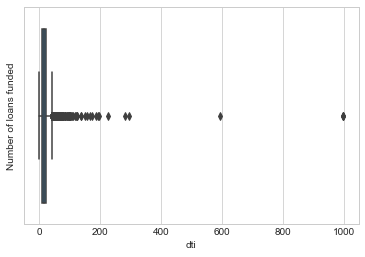

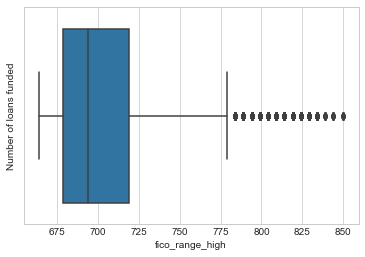

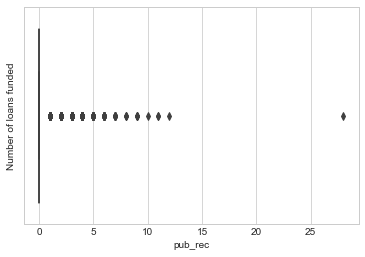

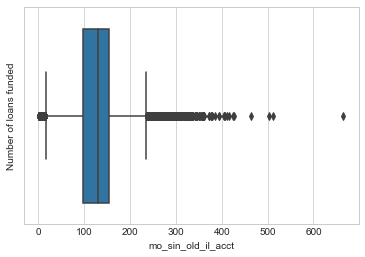

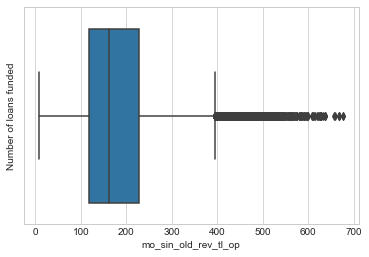

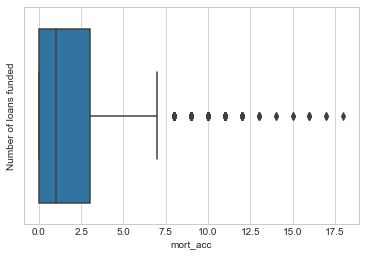

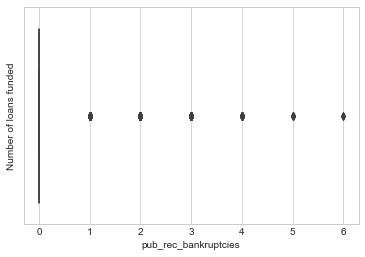

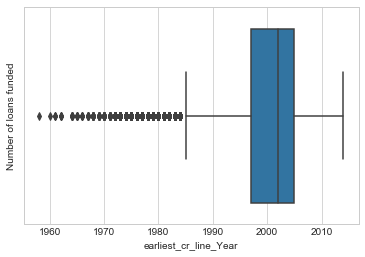

In [129]:
#fig, ((axis1, axis2, axis3), (axis4, axis5, axis6), (axis7, axis8, axis9), (axis10, axis11, axis12),) = plt.subplots(4,3, sharex=False, figsize=(3,3))
for ind, col in enumerate(drop_list):
    plt.figure(ind)
    sns.boxplot(col, data=df)
    plt.xlabel(col)
    plt.ylabel('Number of loans funded')

In the above analysis, we have examined the distribution of each variable, and its relation with the final response variable (loan_status). In the following, we want to check the relationships between variables. 

In [130]:
df.dtypes

loan_amnt                float64
term                       int64
int_rate                 float64
installment              float64
sub_grade                 object
emp_length                object
home_ownership            object
annual_inc               float64
verification_status       object
issue_d                   object
loan_status               object
purpose                   object
addr_state                object
dti                      float64
fico_range_high          float64
pub_rec                  float64
initial_list_status       object
application_type          object
mo_sin_old_il_acct       float64
mo_sin_old_rev_tl_op     float64
mort_acc                 float64
pub_rec_bankruptcies     float64
earliest_cr_line_Year      int64
dtype: object

In [131]:
float_list = df.select_dtypes(exclude=['object']).columns

Look at the Correlation matrix between numerical values.

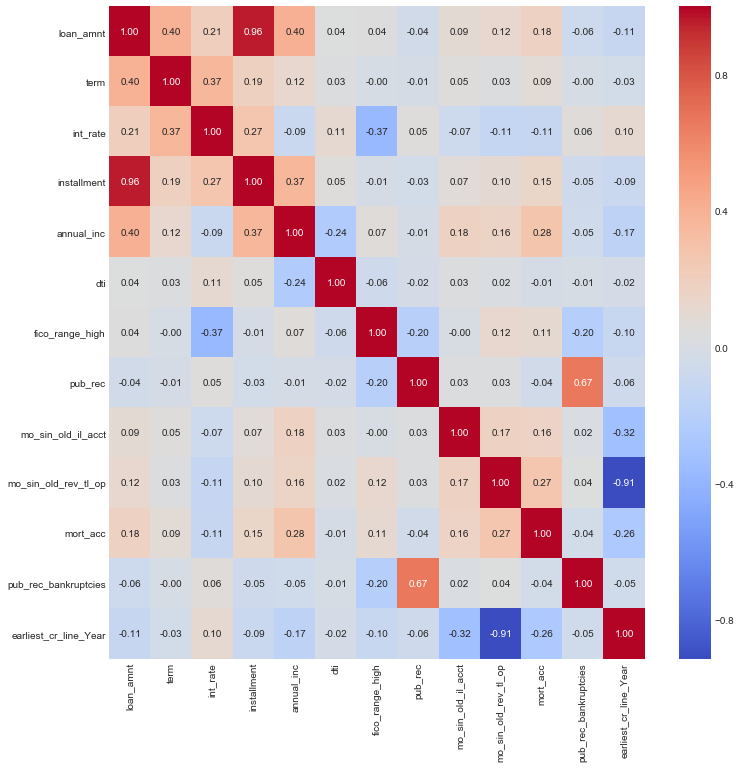

In [132]:
fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
cm_df = sns.heatmap(df[float_list].corr(),annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax)

We can see that "installment" & "loan_amnt" are highly correlated, while "earliest_cr_line_Year" & "mo_sin_old_rev_tl_op" are highly anti-correlated. "pub_rec"&"pub_Rec_bankruptcies" are fairly correlated as well. 

We will save the list of these collinear features and not drop them at this moment. 

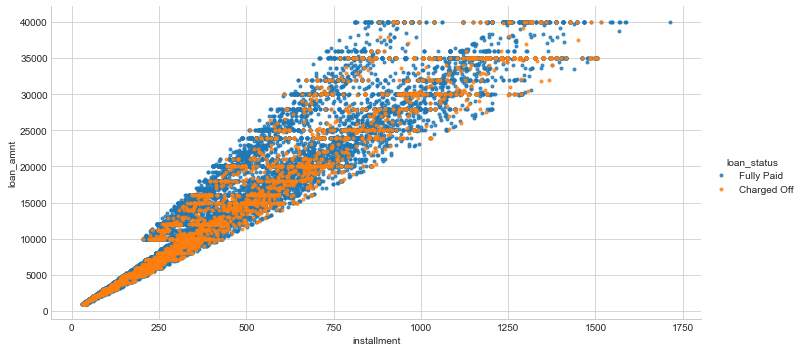

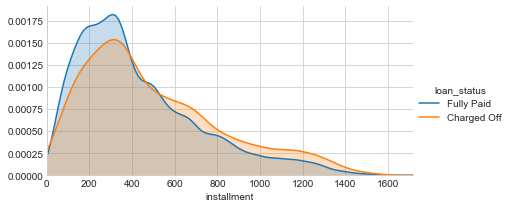

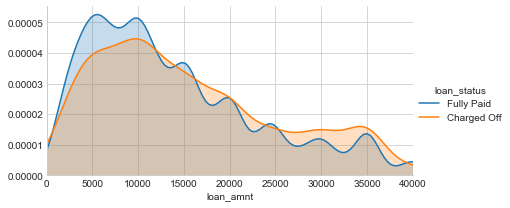

In [133]:
# installment vs loan_amount
sns.lmplot('installment', 'loan_amnt', hue='loan_status', data=df, fit_reg=False, markers='.', aspect=2)

# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(df, hue = 'loan_status', aspect=2)
facet.map(sns.kdeplot, 'installment', shade=True)
facet.set(xlim=(0, df['installment'].max()))
facet.add_legend()
#plt.xlim(0, 80)


facet = sns.FacetGrid(df, hue = 'loan_status', aspect=2)
facet.map(sns.kdeplot, 'loan_amnt', shade=True)
facet.set(xlim=(0, df['loan_amnt'].max()))
facet.add_legend()

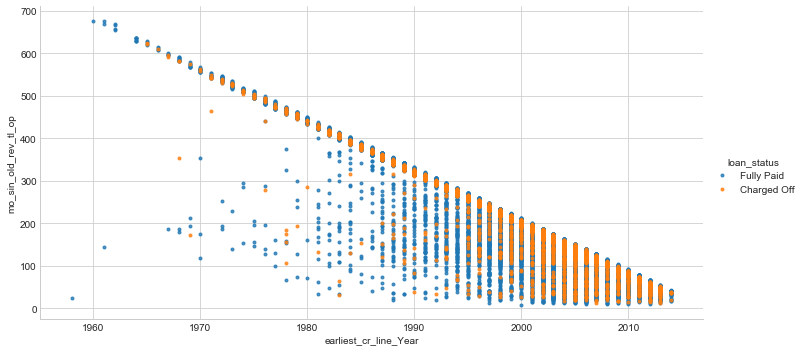

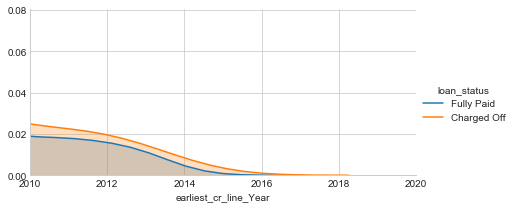

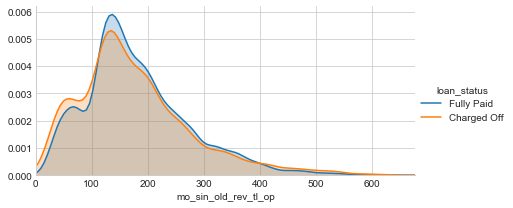

In [134]:
# "earliest_cr_line_Year" vs "mo_sin_old_rev_tl_op"
sns.lmplot('earliest_cr_line_Year', 'mo_sin_old_rev_tl_op', hue='loan_status', data=df, fit_reg=False, markers='.', aspect=2)

# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(df, hue = 'loan_status', aspect=2)
facet.map(sns.kdeplot, 'earliest_cr_line_Year', shade=True)
facet.set(xlim=(0, df['earliest_cr_line_Year'].max()))
facet.add_legend()
plt.xlim(2010, 2020)


facet = sns.FacetGrid(df, hue = 'loan_status', aspect=2)
facet.map(sns.kdeplot, 'mo_sin_old_rev_tl_op', shade=True)
facet.set(xlim=(0, df['mo_sin_old_rev_tl_op'].max()))
facet.add_legend()

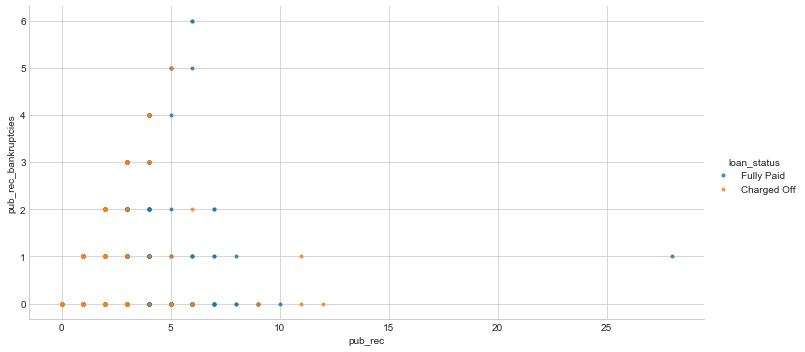

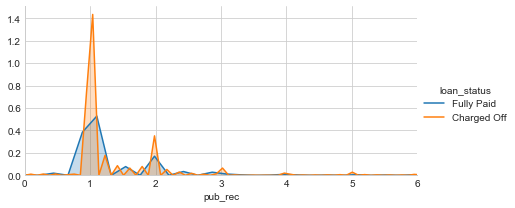

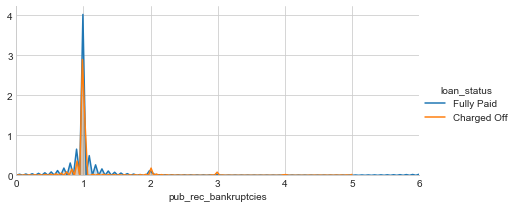

In [135]:
# "pub_rec"&"pub_Rec_bankruptcies"
sns.lmplot('pub_rec', 'pub_rec_bankruptcies', hue='loan_status', data=df, fit_reg=False, markers='.', aspect=2)

# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(df, hue = 'loan_status', aspect=2)
facet.map(sns.kdeplot, 'pub_rec', shade=True)
facet.set(xlim=(0, df['pub_rec'].max()))
facet.add_legend()
plt.xlim(0,6)

facet = sns.FacetGrid(df, hue = 'loan_status', aspect=2)
facet.map(sns.kdeplot, 'pub_rec_bankruptcies', shade=True)
facet.set(xlim=(0, df['pub_rec_bankruptcies'].max()))
facet.add_legend()

In [136]:
features_corr = ['installment','loan_amnt',"pub_rec", "pub_rec_bankruptcies","earliest_cr_line_Year", "mo_sin_old_rev_tl_op"]

As our final exploratory plot, we will create pairs plot to visualize relationships between multiple pairs of variables as well as distributions of single variables.

In [137]:
""" 
# Extract the columns to  plot
plot_data = df[float_list]

# Replace the inf with nan
#plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})

# Rename columns 
#plot_data = plot_data.rename(columns = {'Site EUI (kBtu/ft²)': 'Site EUI', 'Weather Normalized Source EUI (kBtu/ft²)': 'Weather Norm EUI', 'log_Total GHG Emissions (Metric Tons CO2e)': 'log GHG Emissions'})

# Drop na values
plot_data = plot_data.dropna()

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)
# Create the pairgrid object
#grid = sns.PairGrid(data = plot_data, size = 3)

# Upper is a scatter plot
grid.map_upper(plt.scatter, color = 'red', alpha = 0.6)

# Diagonal is a histogram
grid.map_diag(plt.hist, color = 'red', edgecolor = 'black')

# Bottom is correlation and density plot
grid.map_lower(corr_func);
grid.map_lower(sns.kdeplot, cmap = plt.cm.Reds)

# Title for entire plot
plt.suptitle('Pairs Plot of Energy Data', size = 36, y = 1.02);
"""

' \n# Extract the columns to  plot\nplot_data = df[float_list]\n\n# Replace the inf with nan\n#plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})\n\n# Rename columns \n#plot_data = plot_data.rename(columns = {\'Site EUI (kBtu/ft²)\': \'Site EUI\', \'Weather Normalized Source EUI (kBtu/ft²)\': \'Weather Norm EUI\', \'log_Total GHG Emissions (Metric Tons CO2e)\': \'log GHG Emissions\'})\n\n# Drop na values\nplot_data = plot_data.dropna()\n\n# Function to calculate correlation coefficient between two columns\ndef corr_func(x, y, **kwargs):\n    r = np.corrcoef(x, y)[0][1]\n    ax = plt.gca()\n    ax.annotate("r = {:.2f}".format(r),\n                xy=(.2, .8), xycoords=ax.transAxes,\n                size = 20)\n# Create the pairgrid object\n#grid = sns.PairGrid(data = plot_data, size = 3)\n\n# Upper is a scatter plot\ngrid.map_upper(plt.scatter, color = \'red\', alpha = 0.6)\n\n# Diagonal is a histogram\ngrid.map_diag(plt.hist, color = \'red\', edgecolor = \'black\')\n\n# B

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30612 entries, 8 to 324928
Data columns (total 23 columns):
loan_amnt                30612 non-null float64
term                     30612 non-null int64
int_rate                 30612 non-null float64
installment              30612 non-null float64
sub_grade                30612 non-null object
emp_length               30612 non-null object
home_ownership           30612 non-null object
annual_inc               30612 non-null float64
verification_status      30612 non-null object
issue_d                  30612 non-null object
loan_status              30612 non-null object
purpose                  30612 non-null object
addr_state               30612 non-null object
dti                      30593 non-null float64
fico_range_high          30612 non-null float64
pub_rec                  30612 non-null float64
initial_list_status      30612 non-null object
application_type         30612 non-null object
mo_sin_old_il_acct       29925 non-nul

## 5. Feature Engineering
<a id="featureeng"></a>
I will take the raw data and extract or create new features, including: creating dummy variables, transformation of variables, fill in missing values. 

In [139]:
df.shape

(30612, 23)

In [140]:
df.dtypes

loan_amnt                float64
term                       int64
int_rate                 float64
installment              float64
sub_grade                 object
emp_length                object
home_ownership            object
annual_inc               float64
verification_status       object
issue_d                   object
loan_status               object
purpose                   object
addr_state                object
dti                      float64
fico_range_high          float64
pub_rec                  float64
initial_list_status       object
application_type          object
mo_sin_old_il_acct       float64
mo_sin_old_rev_tl_op     float64
mort_acc                 float64
pub_rec_bankruptcies     float64
earliest_cr_line_Year      int64
dtype: object

In [141]:
df.sample(5)

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,fico_range_high,pub_rec,initial_list_status,application_type,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mort_acc,pub_rec_bankruptcies,earliest_cr_line_Year
91776,7150.0,36,16.99,254.89,D1,6,RENT,4.722231,Verified,Apr-2017,Fully Paid,debt_consolidation,SC,25.95,679.0,0.0,w,Individual,109.0,105.0,0.0,0.0,2008
35727,8000.0,36,10.91,261.57,B4,10,OWN,5.079185,Source Verified,Jun-2017,Fully Paid,debt_consolidation,NJ,6.91,674.0,1.0,f,Individual,80.0,259.0,1.0,1.0,1995
12267,40000.0,60,16.02,973.15,C5,10,MORTGAGE,5.107213,Verified,Jun-2017,Fully Paid,debt_consolidation,CA,19.75,694.0,0.0,w,Individual,120.0,247.0,3.0,0.0,1996
176282,18000.0,60,12.74,407.17,C1,10,MORTGAGE,4.863329,Not Verified,Jan-2017,Charged Off,debt_consolidation,CA,12.31,699.0,0.0,w,Individual,133.0,127.0,3.0,0.0,2005
82542,5500.0,36,13.49,186.62,C2,1,RENT,4.602071,Source Verified,Apr-2017,Fully Paid,debt_consolidation,FL,14.52,744.0,0.0,f,Individual,136.0,56.0,0.0,0.0,2005


In [142]:
missing_values_table(df)

Your selected dataframe has 23 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
mo_sin_old_il_acct,687,2.2
dti,19,0.1


There are only 2 variables with missing values (with very small percentage). Those 2 are not categorical variables. I will fill those with the median values. 

In [143]:
# pandas_profiling.ProfileReport(df)

In [144]:
# BAD: test data leakage. 
#df['mo_sin_old_il_acct'] = df['mo_sin_old_il_acct'].fillna(df['dti'].median())
#df['dti'] = df['dti'].fillna(df['dti'].median())

In [145]:
missing_values_table(df)

Your selected dataframe has 23 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
mo_sin_old_il_acct,687,2.2
dti,19,0.1


### 5.1 Dummy Variables
<a id="dummies"></a>

Create dummy variables for the categorical variables. 

In [146]:
df = pd.get_dummies(df, columns=['sub_grade','home_ownership','verification_status','purpose','addr_state','initial_list_status','application_type'], drop_first=True)

After one-hot encoding, we have 30612 observations with 116 features. 

In [147]:
df.shape

(30612, 116)

In [148]:
df.sample(5)

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,issue_d,loan_status,dti,fico_range_high,pub_rec,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mort_acc,pub_rec_bankruptcies,earliest_cr_line_Year,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_OTHERS,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WY,initial_list_status_w,application_type_Joint App
145225,25000.0,60,30.84,821.79,2,5.146131,Feb-2017,Charged Off,20.39,669.0,0.0,116.0,89.0,1.0,0.0,2007,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
318221,3000.0,36,10.42,97.40,1,4.477136,Jul-2017,Fully Paid,25.92,674.0,0.0,101.0,84.0,1.0,0.0,2009,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
66819,2500.0,36,7.99,78.33,7,5.000004,May-2017,Fully Paid,0.53,829.0,0.0,152.0,433.0,1.0,0.0,1981,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
41254,22200.0,60,15.05,528.72,1,4.954247,Jun-2017,Fully Paid,21.67,679.0,1.0,119.0,138.0,4.0,1.0,2005,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
109979,4000.0,36,5.32,120.46,10,4.744301,Mar-2017,Fully Paid,7.94,789.0,0.0,172.0,99.0,2.0,0.0,2002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### 5.2 Train/Test data split
<a id="split"></a>

We will use loans funded on earlier dates to predict the outcome of loans funded on later dates

We use "issue_d". 

In [149]:
df['issue_d'].sample()

313146    Jul-2017
Name: issue_d, dtype: object

In [150]:
df['issue_d'].isnull().any()

False

In [151]:
df.isnull().any()

loan_amnt                              False
term                                   False
int_rate                               False
installment                            False
emp_length                             False
annual_inc                             False
issue_d                                False
loan_status                            False
dti                                     True
fico_range_high                        False
pub_rec                                False
mo_sin_old_il_acct                      True
mo_sin_old_rev_tl_op                   False
mort_acc                               False
pub_rec_bankruptcies                   False
earliest_cr_line_Year                  False
sub_grade_A2                           False
sub_grade_A3                           False
sub_grade_A4                           False
sub_grade_A5                           False
sub_grade_B1                           False
sub_grade_B2                           False
sub_grade_

"issue_d" has month and year, no null values.

In [152]:
df['issue_d'] = pd.to_datetime(df['issue_d'])

In [153]:
df['issue_d'].sample(5)

159051   2017-02-01
143628   2017-02-01
279753   2017-08-01
150444   2017-02-01
165796   2017-02-01
Name: issue_d, dtype: datetime64[ns]

In [154]:
df['issue_d'].describe()

count                   30612
unique                      9
top       2017-01-01 00:00:00
freq                     5912
first     2017-01-01 00:00:00
last      2017-09-01 00:00:00
Name: issue_d, dtype: object

There are only 9 unique values, because this data is only for the first 3 quarters of the 2017. The first loans were issued in Jan 2017 and the last loans were issued in Sep 2017. The busiest month was Jan, with 5912 loans funded in that month. Let's further check the distribution of loans funded per month.

Text(0.5,1,'Loans funded per month')

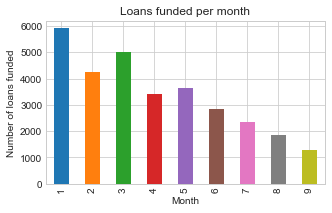

In [155]:
plt.figure(figsize=(5,3))
df['issue_d'].dt.month.value_counts().sort_index().plot.bar()
plt.xlabel('Month')
plt.ylabel('Number of loans funded')
plt.title('Loans funded per month')

We will split the train/test sample at 9:1. 

In [156]:
df_train = df.loc[df['issue_d']  < df['issue_d'].quantile(0.9)]
df_test =  df.loc[df['issue_d'] >= df['issue_d'].quantile(0.9)]

In [157]:
print('Number of loans in the partition:   ', df_train.shape[0] + df_test.shape[0])
print('Number of loans in the full dataset:', df.shape[0])

Number of loans in the partition:    30612
Number of loans in the full dataset: 30612


Let's look at the summary statistics of the issue dates in the train/test sets.

In [158]:
df_train['issue_d'].describe()

count                   27451
unique                      7
top       2017-01-01 00:00:00
freq                     5912
first     2017-01-01 00:00:00
last      2017-07-01 00:00:00
Name: issue_d, dtype: object

In [159]:
df_test['issue_d'].describe()

count                    3161
unique                      2
top       2017-08-01 00:00:00
freq                     1863
first     2017-08-01 00:00:00
last      2017-09-01 00:00:00
Name: issue_d, dtype: object

Now we can delete the "issue_d"

In [160]:
df_train.drop('issue_d', axis=1, inplace=True)
df_test.drop('issue_d', axis=1, inplace=True)

Now separate the predictor variables from the target variable

In [161]:
X_train = df_train.drop('loan_status', axis=1)
y_train = df_train.loc[:, 'loan_status']

X_test = df_test.drop('loan_status', axis=1)
y_test = df_test.loc[:, 'loan_status']

### 5.3 Imputing missing values
<a id="imputing"></a>   



Let's check our train data.

In [162]:
missing_values_table(df)

Your selected dataframe has 116 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
mo_sin_old_il_acct,687,2.2
dti,19,0.1


As the percentage of missing data is very low, we will use a relatively simple method, median imputation, which replaces all the missing values in a column with the median value of the column.

We will create an imputer object with the strategy set to median. We then train this object on the **training** data and uset it to fill in the missing values in **both** the training and testing data. This means that missing values in the *test* data are filled in with the corresponding median value from the *training* data. We do it this way to avoid the problem of test data leakage. 

In [163]:
# Create an imputer object with a median filling strategy
imputer = Imputer(strategy='median')

# Train on the training features
imputer.fit(X_train)

# Transform both training and testing data
X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [164]:
missing_values_table(X_train)

Your selected dataframe has 114 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [165]:
X_test.dtypes

loan_amnt                              float64
term                                   float64
int_rate                               float64
installment                            float64
emp_length                             float64
annual_inc                             float64
dti                                    float64
fico_range_high                        float64
pub_rec                                float64
mo_sin_old_il_acct                     float64
mo_sin_old_rev_tl_op                   float64
mort_acc                               float64
pub_rec_bankruptcies                   float64
earliest_cr_line_Year                  float64
sub_grade_A2                           float64
sub_grade_A3                           float64
sub_grade_A4                           float64
sub_grade_A5                           float64
sub_grade_B1                           float64
sub_grade_B2                           float64
sub_grade_B3                           float64
sub_grade_B4 

### 5.4 Feature Scaling
<a id="scaling"></a>  


As features are measured in different units, they cover different ranges. Some ML models, such as SVM, KNN that take into account distance measures between observations are therefore significantly affected by the range of the features and scaling allows them to learn. While some methods, such as Linear Regression and Ransom Forest do not actually require featuer scaling, it's still best practice to take this step when we are comparing multiple algorithms. 

Removing mean and dividing the standard deviation of features respectively. 

In [166]:
from sklearn.preprocessing import StandardScaler

In [167]:
# Create an imputer object with a median filling strategy
scaler = StandardScaler()

# Train on the training features
scaler.fit(X_train)

# Transform both training and testing data
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [168]:
y_train.sample(5)

197536     Fully Paid
141705     Fully Paid
157270     Fully Paid
124049    Charged Off
199623     Fully Paid
Name: loan_status, dtype: object

In [169]:
# Next, I will convert the "loan_status" column to a 0/1 "charged off" column. Fully Paid:0 Charged Off: 1
y_train = y_train.apply(lambda s: np.float(s == 'Charged Off'))
y_test = y_test.apply(lambda s: np.float(s == 'Charged Off'))

In [222]:
print ('The number of fully paid, value of 0, is: ', sum(y_train == 0))

SyntaxError: unexpected EOF while parsing (<ipython-input-222-c12250fd5641>, line 1)

In [214]:
print ('The number of fully paid, value of 0, is: ', sum(y_train == 1))

The number of charged off, value of 1, is:  3004


Again, the labels of the target are very unbalanced, with ratios of 0 to 1 at 8:1. This takes to be taken care of in the following modeling process.

In [183]:
# The dataframe is ready to be represented as matrix that is amemnable to sklearn. 
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

In [190]:
X_train.shape

(27451, 114)

For the training data, I have 27451 instances and 114 feature vectors for each instance. 

## 6. Modeling
<a id="modeling"></a>  

We will compare 10 of the most popular classifiers and evaluate their performance using a stratified kfold cross validation procedure.  ML models using the Scikit-Learn library:
1. Logistic Regression
2. Linear Discriminant Analysis
3. SVC
4. KNN
5. Random Forest (RFC)
6. Decision Tree
7. Extra Trees (ExtC)
8. AdaBoost (Ada)
9. Gradient Boosting (GBC)
10. Multiple layer perceptron (neural network)

*I am using Stratified K Fold because there the classes are unbalanced. I do not want any folds to have only 1 particular class or even 1 class dominating the other one as it may create a bias in that particular fold. Stratification makes sure that the percentage of samples for each class is similar across folds(if not same).

### 6.1 Cross Validation
<a id="cv"></a>  

Because the classes are unbalanced, I am using Stratified K Fold CV. I don't want any folds to have only 1 particular class or even 1 class dominating the other one as it may create a bias in that particular fold. Stratification makes sure that the percentage of samples for each class is similar across folds (if not same). 

In [191]:
def stratified_cv(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    stratified_k_fold = cross_validation.StratifiedKFold(y, n_folds=n_folds, shuffle=shuffle)
    y_pred = y.copy()
    for ii, jj in stratified_k_fold:
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[jj] = clf.predict(X_test)
    return y_pred

In [226]:
"""

# define CV for differnt classifiers. 
y_pred_LR = stratified_cv(X_train, y_train, linear_model.LogisticRegression)

y_pred_PA = stratified_cv(X_train, y_train, linear_model.PassiveAggressiveClassifier)

y_pred_GB = stratified_cv(X_train, y_train, GradientBoostingClassifier)

y_pred_SV = stratified_cv(X_train, y_train, SVC)

y_pred_RF  =  stratified_cv(X_train, y_train, RandomForestClassifier)

y_pred_KNN = stratified_cv(X_train, y_train, KNeighborsClassifier)
"""


In [215]:
"""
# print accuracy scores
print('Passive Aggressive Classifier: {:.2f}'.format(metrics.accuracy_score(y_train, y_pred_PA)))
print('Gradient Boosting Classifier:  {:.2f}'.format(metrics.accuracy_score(y_train, y_pred_GB)))
print('Support vector machine(SVM):   {:.2f}'.format(metrics.accuracy_score(y_train, y_pred_SV)))
print('Random Forest Classifier:      {:.2f}'.format(metrics.accuracy_score(y_train, y_pred_RF)))
print('K Nearest Neighbor Classifier: {:.2f}'.format(metrics.accuracy_score(y_train, y_pred_KNN)))
print('Logistic Regression:           {:.2f}'.format(metrics.accuracy_score(y_train, y_pred_LR)))
"""

Passive Aggressive Classifier: 0.82
Gradient Boosting Classifier:  0.89
Support vector machine(SVM):   0.89
Random Forest Classifier:      0.89
K Nearest Neighbor Classifier: 0.88
Logistic Regression:           0.89


Scores seem OK. However, if I predict all of the labels 0, what would I get as accuracy rate? Let's see.

In [227]:
# CV model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [229]:
# Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})



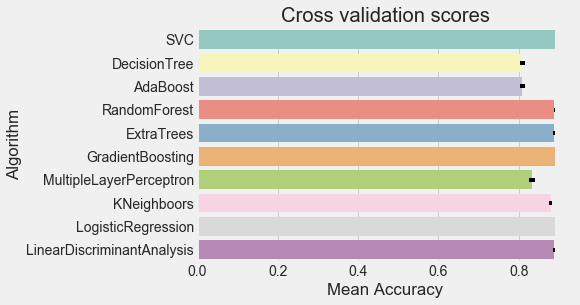

In [230]:
# plot the CV scores
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [232]:
print(cv_res)

   CrossValMeans  CrossValerrors                   Algorithm
0       0.890423        0.000374                         SVC
1       0.808713        0.006010                DecisionTree
2       0.809222        0.007098                    AdaBoost
3       0.888601        0.000932                RandomForest
4       0.887873        0.002156                  ExtraTrees
5       0.889986        0.000901            GradientBoosting
6       0.833193        0.008146     MultipleLayerPerceptron
7       0.879458        0.003333                 KNeighboors
8       0.889949        0.001053          LogisticRegression
9       0.887800        0.001989  LinearDiscriminantAnalysis


In [231]:
print('Dump Classifier: {:.2f}'.format(metrics.accuracy_score(y_train, [0 for ii in y_train.tolist()])))

Dump Classifier: 0.89


This is because the unbalanced dataset problem. Since one class (0 class) is 8 times of other class. One could get fairly accurate prediction if I predict the common class. 

Here, what I need to look at as a metric if the classifier is doing well is to see the errors over the classes. Confusion matrices give a perfect way to see the distribution. I will do this in the next step.

### 6.2 Confusion Matrices

If you have an unbalanced dataset problem or if you care accuracy of one class over other(maybe false-positives are not so bad for you but you definitely do not want any false negatives), then you could display the class accuracies in confusion matrices. 

As a reminder, I am trying to predict if a borrower's loan will be fully paid (0) or charged off (1). I could probably get away with some false positives (loans that are fully paid but are predicted to be charged off). However, we do not want to lend loans to borrowers that are predicted to be fully paid but eventually charged off (false negative), especially under current economy environment and big loans. 

In [242]:
# heat map with the confusion matrix on top.
pass_agg_conf_matrix = metrics.confusion_matrix(y_train, stratified_cv(X_train, y_train, LinearDiscriminantAnalysis))

logistic_reg_conf_matrix = metrics.confusion_matrix(y_train, stratified_cv(X_train, y_train, linear_model.LogisticRegression))

k_neighbors_conf_matrix = metrics.confusion_matrix(y_train, stratified_cv(X_train, y_train, neighbors.KNeighborsClassifier))

MLP_conf_matrix = metrics.confusion_matrix(y_train, stratified_cv(X_train, y_train, MLPClassifier))

grad_ens_conf_matrix = metrics.confusion_matrix(y_train, stratified_cv(X_train, y_train, ensemble.GradientBoostingClassifier))

ETC_conf_matrix = metrics.confusion_matrix(y_train, stratified_cv(X_train, y_train, ExtraTreesClassifier))

random_forest_conf_matrix = metrics.confusion_matrix(y_train, stratified_cv(X_train, y_train, ensemble.RandomForestClassifier))

Ada_conf_matrix = metrics.confusion_matrix(y_train, stratified_cv(X_train, y_train, AdaBoostClassifier(DecisionTreeClassifier)))

decision_conf_matrix = metrics.confusion_matrix(y_train, stratified_cv(X_train, y_train, DecisionTreeClassifier))
                                         
svm_svc_conf_matrix = metrics.confusion_matrix(y_train, stratified_cv(X_train, y_train, SVC))
                                           
dumb_conf_matrix = metrics.confusion_matrix(y_train, [0 for ii in y_train.tolist()]); # ignore the warning as they are all 0

conf_matrix = {
                1: {
                    'matrix': pass_agg_conf_matrix,
                    'title': 'Linear Discriminant Analysis',
                   },
                2: {
                    'matrix': logistic_reg_conf_matrix,
                    'title': 'Logistic Regression',
                   },
                3: {
                    'matrix': k_neighbors_conf_matrix,
                    'title': 'K Nearest Neighbors',
                   },
                4: {
                    'matrix': MLP_conf_matrix,
                    'title': 'Multiple Layer Perceptron',
                   },
                5: {
                    'matrix': grad_ens_conf_matrix,
                    'title': 'Gradient Boosting',
                   },
                6: {
                    'matrix': ETC_conf_matrix,
                    'title': 'Extra Trees',
                   },
                7: {
                    'matrix': random_forest_conf_matrix,
                    'title': 'Random Forest',
                   },
                8: {
                    'matrix': Ada_conf_matrix,
                    'title': 'Ada Boost',
                   },
                9: {
                    'matrix': decision_conf_matrix,
                    'title': 'Random Forest',
                   },
                10: {
                    'matrix': svm_svc_conf_matrix,
                    'title': 'Support Vector Machine',
                   },
                11: {
                    'matrix': dumb_conf_matrix,
                    'title': 'Dumb',
                   },
}

KeyboardInterrupt: 

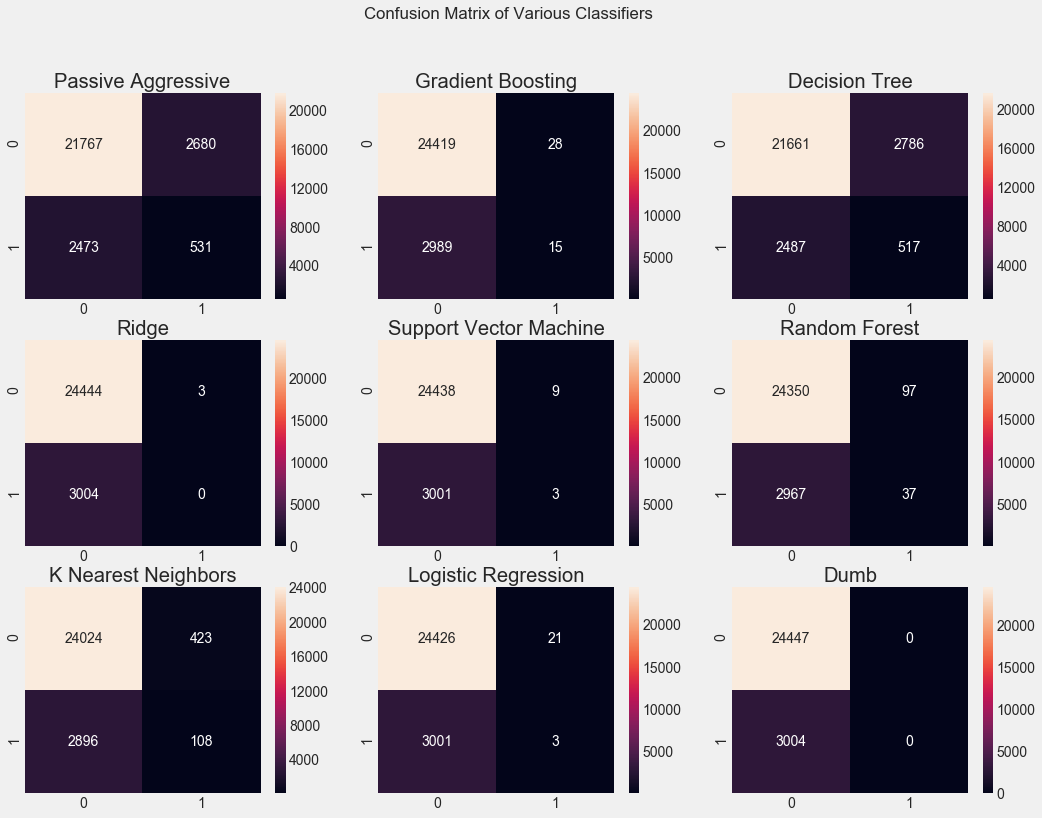

In [224]:
fix, ax = plt.subplots(figsize=(16, 12))
plt.suptitle('Confusion Matrix of Various Classifiers')
for ii, values in conf_matrix.items():
    matrix = values['matrix']
    title = values['title']
    plt.subplot(3, 3, ii) # starts from 1
    plt.title(title);
    sns.heatmap(matrix, annot=True,  fmt='')

We want to measure not just class distribution, but also a more abstract measure, e.g., precision, recall or f1 score. I use classification_report function under the metrics submodule.

In [225]:
print('Passive Aggressive Classifier:\n {}\n'.format(metrics.classification_report(y_train, stratified_cv(X_train, y_train, linear_model.PassiveAggressiveClassifier))))
print('Gradient Boosting Classifier:\n {}\n'.format(metrics.classification_report(y_train, stratified_cv(X_train, y_train, ensemble.GradientBoostingClassifier))))
print('Support vector machine(SVM):\n {}\n'.format(metrics.classification_report(y_train, stratified_cv(X_train, y_train, svm.SVC))))
print('Random Forest Classifier:\n {}\n'.format(metrics.classification_report(y_train, stratified_cv(X_train, y_train, ensemble.RandomForestClassifier))))
print('K Nearest Neighbor Classifier:\n {}\n'.format(metrics.classification_report(y_train, stratified_cv(X_train, y_train, neighbors.KNeighborsClassifier))))
print('Logistic Regression:\n {}\n'.format(metrics.classification_report(y_train, stratified_cv(X_train, y_train, linear_model.LogisticRegression))))
print('Dump Classifier:\n {}\n'.format(metrics.classification_report(y_train, [0 for ii in y_train.tolist()]))); # ignore the warning as they are all 0


Passive Aggressive Classifier:
              precision    recall  f1-score   support

        0.0       0.90      0.89      0.90     24447
        1.0       0.16      0.16      0.16      3004

avg / total       0.82      0.81      0.81     27451


Gradient Boosting Classifier:
              precision    recall  f1-score   support

        0.0       0.89      1.00      0.94     24447
        1.0       0.45      0.01      0.01      3004

avg / total       0.84      0.89      0.84     27451


Support vector machine(SVM):
              precision    recall  f1-score   support

        0.0       0.89      1.00      0.94     24447
        1.0       0.31      0.00      0.00      3004

avg / total       0.83      0.89      0.84     27451


Random Forest Classifier:
              precision    recall  f1-score   support

        0.0       0.89      1.00      0.94     24447
        1.0       0.19      0.01      0.02      3004

avg / total       0.81      0.89      0.84     27451


K Nearest Neighb

### 6.3 The best model

I decide to do ensemble modeling with these models: SVC, RF, GB, LR, LDA

In [ ]:
#gbc = ensemble.GradientBoostingClassifier()
#gbc.fit(X_train, y_train)

In [ ]:
"""
# Get feature importance from the classifier
feature_importance = gbc.feature_importances_
# Normalize The Features
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(16, 12))
plt.barh(pos, feature_importance[sorted_idx], align='center', color='#7A68A6')
plt.yticks(pos, np.asanyarray(df.columns.tolist())[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
"""

## 7. Hyperparameter tunning on the best model
<a id="hyper"></a>  


### 7.1 Grid Search for the best parameters. 

## 8. Evaluate the best model on the testing set
<a id="evaluate"></a>  


In [ ]:
# Read in the CSV file 
DSLoanTrain = pd.read_csv('../input/loan-clean-version1.csv')
#DSLoanTrain = pd.read_csv('../input/accepted_2007_to_2017Q3.csv')
DSLoanTrain.head()

In [ ]:
DSLoanTrain.dtypes

In [ ]:
DSLoanTrain[DSLoanTrain.isnull().any(axis=1)]

In [ ]:
class_mapping = {label:idx for idx, label in enumerate(np.unique(DSLoanTrain['term']))}
DSLoanTrain['term']=DSLoanTrain['term'].map(class_mapping)

class_mapping = {label:idx for idx, label in enumerate(np.unique(DSLoanTrain['grade']))}
DSLoanTrain['grade']=DSLoanTrain['grade'].map(class_mapping)

class_mapping = {label:idx for idx, label in enumerate(np.unique(DSLoanTrain['emp_length']))}
DSLoanTrain['emp_length']=DSLoanTrain['emp_length'].map(class_mapping)

class_mapping = {label:idx for idx, label in enumerate(np.unique(DSLoanTrain['home_ownership']))}
DSLoanTrain['home_ownership']=DSLoanTrain['home_ownership'].map(class_mapping)

class_mapping = {label:idx for idx, label in enumerate(np.unique(DSLoanTrain['verification_status']))}
DSLoanTrain['verification_status']=DSLoanTrain['verification_status'].map(class_mapping)

class_mapping = {label:idx for idx, label in enumerate(np.unique(DSLoanTrain['purpose']))}
DSLoanTrain['purpose']=DSLoanTrain['purpose'].map(class_mapping)

class_mapping = {label:idx for idx, label in enumerate(np.unique(DSLoanTrain['addr_state']))}
DSLoanTrain['addr_state']=DSLoanTrain['addr_state'].map(class_mapping)

class_mapping = {label:idx for idx, label in enumerate(np.unique(DSLoanTrain['loan_status']))}
DSLoanTrain['loan_status']=DSLoanTrain['loan_status'].map(class_mapping)

In [ ]:
DSLoanTrain['emp_length'].value_counts()

In [ ]:
DSLoanTrain['loan_status'].value_counts()

In [ ]:
# encoding loan_status data by 'find and replace'
#cleanup_nums = {"loan_status": {"Fully Paid":1, "Charged Off":0}}
#DSLoanTrain.replace(cleanup_nums, inplace=True)
#DSLoanTrain.head()

In [ ]:
DSLoanTrain.head()

In [ ]:
DSLoanTrain = DSLoanTrain.select_dtypes(include=[np.number]).interpolate().dropna()
DSLoanTrain = DSLoanTrain.drop(["total_pymnt"], axis=1)
DSLoanTrain = DSLoanTrain.drop(["total_pymnt_inv"], axis=1)
DSLoanTrain = DSLoanTrain.drop(["total_rec_int"], axis=1)

In [ ]:
#
yPredict = DSLoanTrain.loan_status
XClean = DSLoanTrain.drop(["loan_status"], axis=1)

In [ ]:
#
X_train, X_test, y_train, y_test = train_test_split(XClean, yPredict, random_state=42, test_size=0.33)
#clf = RandomForestRegressor(n_jobs=2, n_estimators=1000)
#model = clf.fit(X_train, y_train)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))
mlp.fit(X_train, y_train)

In [ ]:
predictions = mlp.predict(X_test)
print(confusion_matrix(y_test, predictions))

In [ ]:
print(classification_report(y_test,predictions))

In [ ]:
#
X_train, X_test, y_train, y_test = train_test_split(XClean, yPredict, random_state=42, test_size=.33)
clf = RandomForestRegressor(n_jobs=2, n_estimators=1000)
model = clf.fit(X_train, y_train)

In [ ]:
#
headers = ["name", "score"]
values = sorted(zip(X_train.columns, model.feature_importances_), key=lambda x:x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))